In [290]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import norm
import random

In [480]:
def EIF(X, Y, confidence_level, true_feature_importance, base_learner):
    feature_of_interest = 0
    
    K = 10 # will split data into 2K folds
    
    X_df = pd.DataFrame(X)
    Y_df = pd.DataFrame(Y)
    coverage = 0
    splitting_index = [random.randint(0,2*K-1) for i in range(n)]
    X_df['splitting_index'] = splitting_index
    Y_df['splitting_index'] = splitting_index
    v_cumulative = 0
    v_LOCO_cumulative = 0
    v_dot_cumulative = 0
    v_dot_LOCO_cumulative = 0
    n_s = 0
    for k in range(2*K):
        X_train_df = X_df[X_df['splitting_index'] != k]
        X_test_df = X_df[X_df['splitting_index'] == k]
        Y_train_df = Y_df[Y_df['splitting_index'] != k]
        Y_test_df = Y_df[Y_df['splitting_index'] == k]
        Y_bar = Y_test_df.mean()
        S_Y = Y_test_df.var()
        if k < K:
            regression_function = base_learner.fit(X_train_df.drop('splitting_index',axis=1),Y_train_df)
            tmp = (Y_test_df - regression_function.predict(X_test_df.drop('splitting_index',axis=1)))**2
            tmp_2 = (Y_test_df-Y_bar)**2
            S = tmp.mean()
            v_dot = ((tmp/S_Y - S/S_Y*tmp_2/S_Y)**2).mean()
            v = 1-S/S_Y
            v_cumulative += v
            v_dot_cumulative += v_dot
        if k >= K:
            LOCO_regression_function = base_learner.fit(X_train_df.drop([feature_of_interest,'splitting_index'],axis=1),Y_train_df)
            tmp = (Y_test_df - LOCO_regression_function.predict(X_test_df.drop([feature_of_interest,'splitting_index'],axis=1)))**2
            tmp_2 = (Y_test_df-Y_bar)**2
            S = tmp.mean()
            v_dot = ((tmp/S_Y - S/S_Y*tmp_2/S_Y)**2).mean()
            v = 1-S/S_Y
            v_LOCO_cumulative += v
            v_dot_LOCO_cumulative += v_dot
            n_s += len(Y_test_df)
    estimator = ((v_cumulative-v_LOCO_cumulative)/K)[0]
    width_multiplier = (((v_dot_cumulative/(n-n_s)+v_dot_LOCO_cumulative/n_s)/K)[0])**0.5
    CI = (estimator-norm.ppf(1-(1-confidence_level)/2)*width_multiplier,estimator+norm.ppf(1-(1-confidence_level)/2)*width_multiplier)
    
    # evaluate coverage
    if (true_feature_importance >= CI[0]) and (true_feature_importance <= CI[1]):
        coverage += 1
    return(coverage,width_multiplier)

In [485]:
def Floodgate(X, Y, confidence_level, true_feature_importance, correlation, base_learner): #confidence_level needs to be greater than 0.5
    feature_of_interest = 0
    feature_importance = true_feature_importance # true feature importance for evaluation of miscoverage rate
    
    miscoverage = 0
    
# split data for fitting working regression function vs inference
    X_regress = X[:int(n/2)]
    Y_regress = Y[:int(n/2)]
    X_inference = X[int(n/2):]
    Y_inference = Y[int(n/2):]
    
# fit the working regression function
    working_model = base_learner.fit(X_regress,Y_regress)

    number_of_features = X_regress.shape[1]
    feature_of_interest_bool = np.zeros((number_of_features,))
    feature_of_interest_bool[feature_of_interest] += 1
    feature_of_interest_bool = (feature_of_interest_bool>0)
    
# MC re-sampling to estimate expectations in algorithm
    K = 10
    X_MC = np.zeros((1,number_of_features))
 # concatenate re-samples for MC in order to vectorise computing the output of working_model on them
    for i in range(len(Y_inference)):
        feature_MC = np.random.normal(correlation*X_inference[i,1],(1-correlation**2)**0.5,(K,))
        tmp = np.zeros((K,number_of_features))
        tmp[:,feature_of_interest] += feature_MC
        tmp[:,~feature_of_interest_bool] += X_inference[i,~feature_of_interest_bool]
        X_MC = np.concatenate((X_MC,tmp), axis = 0)
    X_MC = X_MC[1:]
    Y_MC = working_model.predict(X_MC)
    Y_MC = Y_MC.reshape((-1,K)).T
    Y_MC_means = Y_MC.mean(axis=0)

    # compute LCB
    R = Y_inference*(working_model.predict(X_inference)-Y_MC_means)
    V = Y_MC.var(axis=0)*(K/(K-1))
    Y_inference_squared = Y_inference**2
    R_bar = R.mean()
    V_bar = V.mean()
    Y_bar = Y_inference.mean()
    Y_squared_bar = Y_inference_squared.mean()
    cov = np.cov(np.array([R,V,Y_inference,Y_inference_squared]))*(Y_inference.shape[0]/(Y_inference.shape[0]-1))
    tmp_var = Y_squared_bar - Y_bar**2
    s = 4*cov[0,0] + R_bar**2/V_bar**2*cov[1,1] + R_bar**2/tmp_var**2*cov[2,2]+4*R_bar**2*Y_bar**2/tmp_var**2*cov[3,3]
    s = s - 4*R_bar/V_bar*cov[0,1] - 4*R_bar/tmp_var*cov[0,2] + 8*R_bar*Y_bar/tmp_var*cov[0,3]
    s = s + 2*R_bar**2/V_bar/tmp_var*cov[1,2] - 4*R_bar**2*Y_bar/V_bar/tmp_var*cov[1,3] - 4*R_bar**2*Y_bar/tmp_var**2*cov[2,3]
    s = s*R_bar**2/V_bar**2/tmp_var**2
    s = s**0.5

    width_multiplier = s/(len(Y_inference))**0.5
    LCB = max(R_bar**2/V_bar/tmp_var-norm.ppf(confidence_level)*width_multiplier,0)

# evaluate coverage
    if (feature_importance < LCB):
        miscoverage += 1
    return(1-miscoverage,width_multiplier,LCB)

In [482]:
# correlated data covariance matrix
def correlated_cov_matrix(number_of_features,correlation):
    cov = np.eye(number_of_features)
    for i in range(number_of_features-1):
        cov[i,i+1] = correlation
        cov[i+1,i] = correlation
    return(cov)

In [483]:
%%time
iterations = 100
confidence_level = 0.8 # needs to be greater than 0.5 to satisfy floodgate's conditions
base_learner = RandomForestRegressor(n_estimators = 1000) # LinearRegression() RandomForestRegressor(n_estimators = 1000) RidgeCV(cv=5)
                             # need to change base_learner in minipatch directly
noise_variance = 1
correlation = 0 # need abs(correlation) < 2/(1+root(5)) = 0.618 for positive definite correlation matrix
coefficient = 1

true_feature_importance = 0 # 0.3249462191 coefficient**2*(1-correlation**2)/(2+2*(coefficient-1)*correlation+coefficient**2+noise_variance)

cumulative_coverages = {'EIF': 0, 'Floodgate': 0}
cumulative_width_multipliers = {'EIF': 0, 'Floodgate': 0}

cumulative_floodgate_overshot = {'Floodgate': 0}
overshot_counter = 0
zero_LCB_counter = 0
for iteration in range(iterations):
    print(iteration)
    
    # generate data
    n = 2500
    mean = np.zeros(4)
    data_cov = correlated_cov_matrix(4,correlation)
    X = np.random.multivariate_normal(mean,data_cov,n)
    noise = np.random.normal(0,noise_variance**0.5,n)
    Y = 1.5*np.sin(X[:,1]*X[:,2]) + 0.25*np.exp(X[:,3]) + noise
#     Y = coefficient*X[:,0]+1*X[:,1]-1*X[:,2] + noise

    EIF_output = EIF(X,Y,confidence_level,true_feature_importance,base_learner)
    Floodgate_output = Floodgate(X,Y,confidence_level,true_feature_importance,correlation,base_learner)

    cumulative_coverages['EIF'] += EIF_output[0]
    cumulative_coverages['Floodgate'] += Floodgate_output[0]

    cumulative_width_multipliers['EIF'] += EIF_output[1]
    cumulative_width_multipliers['Floodgate'] += Floodgate_output[1]

    if Floodgate_output[2] == 0:
        zero_LCB_counter += 1
    if Floodgate_output[0] == 1:
        cumulative_floodgate_overshot['Floodgate'] += true_feature_importance - Floodgate_output[2]
        overshot_counter += 1
if overshot_counter != 0:
    avg_overshot = cumulative_floodgate_overshot['Floodgate']/overshot_counter
else:
    avg_overshot = np.nan
print('EIF coverage is ' + str(cumulative_coverages['EIF']/iterations))
print('Floodgate coverage is ' + str(cumulative_coverages['Floodgate']/iterations))
print('EIF average width multiplier is ' + str(cumulative_width_multipliers['EIF']/iterations))
print('Floodgate average width multiplier is ' + str(cumulative_width_multipliers['Floodgate']/iterations))
print('Floodgate average overshot is ' + str(avg_overshot))
print(zero_LCB_counter)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
EIF coverage is 0.74
Floodgate coverage is 0.94
EIF average width multiplier is 0.03081415899119775
Floodgate average width multiplier is 0.0015495712894417924
Floodgate average overshot is 0.0
94
CPU times: user 3h 22min 43s, sys: 1min 34s, total: 3h 24min 18s
Wall time: 3h 52min 25s


In [ ]:
%%time
# 'for' loop to evaluate performance over varied correlation results 

iterations = 1000
confidence_level = 0.8 # needs to be greater than 0.5 to satisfy floodgate's conditions
base_learner = RidgeCV(cv=5) #  RandomForestRegressor(n_estimators = 1000) RidgeCV(cv=5) LinearRegression()
                                 # need to change base_learner in minipatch directly
correlations =  [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6]
results_true_feature_importance = []

results_EIF_coverage_mean = []
results_Floodgate_coverage_mean = []
results_EIF_width_multiplier_mean = []
results_Floodgate_width_multiplier_mean = []
results_Floodgate_overshot_mean = []
results_zero_LCB_counter_mean = []

results_EIF_coverage_se = []
results_Floodgate_coverage_se = []
results_EIF_width_multiplier_se = []
results_Floodgate_width_multiplier_se = []
results_Floodgate_overshot_se = []
results_zero_LCB_counter_se = []

for correlation in correlations:
    print(correlation)
    
    noise_variance = 1
#     correlation = 0.15 # need abs(correlation) < 2/(1+root(5)) = 0.618 for positive definite correlation matrix
    coefficient = 0

    true_feature_importance = 0 #coefficient**2*(1-correlation**2)/(2+2*(coefficient-1)*correlation+coefficient**2+noise_variance) # 0.3249462191
    
    tmp = np.zeros((6,10))
    counter = 0
    for iteration in range(iterations):
        if iteration%100 == 0:
            print(iteration)
        if iteration%(iterations/10) == 0:
            cumulative_coverages = {'EIF': 0, 'Floodgate': 0}
            cumulative_width_multipliers = {'EIF': 0, 'Floodgate': 0}

            cumulative_floodgate_overshot = {'Floodgate': 0}
            overshot_counter = 0
            zero_LCB_counter = 0

        # generate data
        n = 2500
        mean = np.zeros(4)
        data_cov = correlated_cov_matrix(4,correlation)
        X = np.random.multivariate_normal(mean,data_cov,n)
        noise = np.random.normal(0,noise_variance**0.5,n)
#         Y = 1.5*np.sin(X[:,0]*X[:,1]) + 0.25*np.exp(X[:,2]) + noise
        Y = coefficient*X[:,0]+1*X[:,1]-1*X[:,2] +X[:,3] + noise

        EIF_output = EIF(X,Y,confidence_level,true_feature_importance,base_learner)
        Floodgate_output = Floodgate(X,Y,confidence_level,true_feature_importance,correlation,base_learner)

        cumulative_coverages['EIF'] += EIF_output[0]
        cumulative_coverages['Floodgate'] += Floodgate_output[0]

        cumulative_width_multipliers['EIF'] += EIF_output[1]
        cumulative_width_multipliers['Floodgate'] += Floodgate_output[1]

        if Floodgate_output[2] == 0:
            zero_LCB_counter += 1
        if Floodgate_output[0] == 1:
            cumulative_floodgate_overshot['Floodgate'] += true_feature_importance - Floodgate_output[2]
            overshot_counter += 1
        if iteration%(iterations/10) == (iterations/10)-1:
            if overshot_counter != 0:
                avg_overshot = cumulative_floodgate_overshot['Floodgate']/overshot_counter
            else:
                avg_overshot = np.nan
            tmp[0,counter] = cumulative_coverages['EIF']/(iterations/10)
            tmp[1,counter] = cumulative_coverages['Floodgate']/(iterations/10)
            tmp[2,counter] = cumulative_width_multipliers['EIF']/(iterations/10)
            tmp[3,counter] = cumulative_width_multipliers['Floodgate']/(iterations/10)
            tmp[4,counter] = avg_overshot
            tmp[5,counter] = zero_LCB_counter/(iterations/10)
            counter += 1
    mean = np.nanmean(tmp,axis=1)
    se = np.nanstd(tmp,axis=1)*(1/9)**0.5
    print(mean)
    print(se)
    
    results_EIF_coverage_mean.append(mean[0])
    results_Floodgate_coverage_mean.append(mean[1])
    results_EIF_width_multiplier_mean.append(mean[2])
    results_Floodgate_width_multiplier_mean.append(mean[3])
    results_Floodgate_overshot_mean.append(mean[4])
    results_zero_LCB_counter_mean.append(mean[5])
    results_true_feature_importance.append(true_feature_importance)
    
    results_EIF_coverage_se.append(se[0])
    results_Floodgate_coverage_se.append(se[1])
    results_EIF_width_multiplier_se.append(se[2])
    results_Floodgate_width_multiplier_se.append(se[3])
    results_Floodgate_overshot_se.append(se[4])
    results_zero_LCB_counter_se.append(se[5])
    

In [266]:
results_df_null = pd.DataFrame(data = {'EIF coverage': results_EIF_coverage_mean,'Floodgate coverage': results_Floodgate_coverage_mean,'EIF width multiplier': results_EIF_width_multiplier_mean,'Floodgate width multiplier': results_Floodgate_width_multiplier_mean,'Floodgate overshot': results_Floodgate_overshot_mean,'Floodgate zero LCB counter': results_zero_LCB_counter_mean,'true feature importance': results_true_feature_importance,'EIF coverage SE': results_EIF_coverage_se,'Floodgate coverage SE': results_Floodgate_coverage_se,'EIF width multiplier SE': results_EIF_width_multiplier_se,'Floodgate width multiplier SE': results_Floodgate_width_multiplier_se,'Floodgate overshot SE': results_Floodgate_overshot_se,'Floodgate zero LCB counter SE': results_zero_LCB_counter_se}, index=[0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6])


In [ ]:
%%time
# 'for' loop to evaluate performance over varied SNR results 

iterations = 1000
confidence_level = 0.8 # needs to be greater than 0.5 to satisfy floodgate's conditions
base_learner = RidgeCV(cv=5) #  RandomForestRegressor(n_estimators = 1000) RidgeCV(cv=5) LinearRegression()
                                 # need to change base_learner in minipatch directly
SNRs = [0,0.125,0.25,0.375,0.5,0.625,0.75,0.875,1,1.5,2,2.5,3.75,5,7.5,10,15,25,50,100]
results_true_feature_importance = []

results_EIF_coverage_mean = []
results_Floodgate_coverage_mean = []
results_EIF_width_multiplier_mean = []
results_Floodgate_width_multiplier_mean = []
results_Floodgate_overshot_mean = []
results_zero_LCB_counter_mean = []

results_EIF_coverage_se = []
results_Floodgate_coverage_se = []
results_EIF_width_multiplier_se = []
results_Floodgate_width_multiplier_se = []
results_Floodgate_overshot_se = []
results_zero_LCB_counter_se = []

for SNR in SNRs:
    print(SNR)
    
    noise_variance = 1
    correlation = 0
    coefficient = SNR*noise_variance**0.5
    
    true_feature_importance = coefficient**2*(1-correlation**2)/(2+2*(coefficient-1)*correlation+coefficient**2+noise_variance) # 0.3249462191
    
    tmp = np.zeros((6,10))
    counter = 0
    for iteration in range(iterations):
        if iteration%(iterations/10) == 0:
            cumulative_coverages = {'EIF': 0, 'Floodgate': 0}
            cumulative_width_multipliers = {'EIF': 0, 'Floodgate': 0}

            cumulative_floodgate_overshot = {'Floodgate': 0}
            overshot_counter = 0
            zero_LCB_counter = 0

        # generate data
        n = 2500
        mean = np.zeros(4)
        data_cov = correlated_cov_matrix(4,correlation)
        X = np.random.multivariate_normal(mean,data_cov,n)
        noise = np.random.normal(0,noise_variance**0.5,n)
#         Y = 1.5*np.sin(X[:,0]*X[:,1]) + 0.25*np.exp(X[:,2]) + noise
        Y = coefficient*X[:,0]+1*X[:,1]-1*X[:,2] + noise

        EIF_output = EIF(X,Y,confidence_level,true_feature_importance,base_learner)
        Floodgate_output = Floodgate(X,Y,confidence_level,true_feature_importance,correlation,base_learner)

        cumulative_coverages['EIF'] += EIF_output[0]
        cumulative_coverages['Floodgate'] += Floodgate_output[0]

        cumulative_width_multipliers['EIF'] += EIF_output[1]
        cumulative_width_multipliers['Floodgate'] += Floodgate_output[1]

        if Floodgate_output[2] == 0:
            zero_LCB_counter += 1
        if Floodgate_output[0] == 1:
            cumulative_floodgate_overshot['Floodgate'] += true_feature_importance - Floodgate_output[2]
            overshot_counter += 1
        if iteration%(iterations/10) == (iterations/10)-1:
            if overshot_counter != 0:
                avg_overshot = cumulative_floodgate_overshot['Floodgate']/overshot_counter
            else:
                avg_overshot = np.nan
            tmp[0,counter] = cumulative_coverages['EIF']/(iterations/10)
            tmp[1,counter] = cumulative_coverages['Floodgate']/(iterations/10)
            tmp[2,counter] = cumulative_width_multipliers['EIF']/(iterations/10)
            tmp[3,counter] = cumulative_width_multipliers['Floodgate']/(iterations/10)
            tmp[4,counter] = avg_overshot
            tmp[5,counter] = zero_LCB_counter/(iterations/10)
            counter += 1
    mean = np.nanmean(tmp,axis=1)
    se = np.nanstd(tmp,axis=1)*(1/9)**0.5
   
    results_EIF_coverage_mean.append(mean[0])
    results_Floodgate_coverage_mean.append(mean[1])
    results_EIF_width_multiplier_mean.append(mean[2])
    results_Floodgate_width_multiplier_mean.append(mean[3])
    results_Floodgate_overshot_mean.append(mean[4])
    results_zero_LCB_counter_mean.append(mean[5])
    results_true_feature_importance.append(true_feature_importance)
    
    results_EIF_coverage_se.append(se[0])
    results_Floodgate_coverage_se.append(se[1])
    results_EIF_width_multiplier_se.append(se[2])
    results_Floodgate_width_multiplier_se.append(se[3])
    results_Floodgate_overshot_se.append(se[4])
    results_zero_LCB_counter_se.append(se[5])
    

In [302]:
results_df_SNR_1 = pd.DataFrame(data = {'EIF coverage': results_EIF_coverage_mean,'Floodgate coverage': results_Floodgate_coverage_mean,'EIF width multiplier': results_EIF_width_multiplier_mean,'Floodgate width multiplier': results_Floodgate_width_multiplier_mean,'Floodgate overshot': results_Floodgate_overshot_mean,'Floodgate zero LCB counter': results_zero_LCB_counter_mean,'true feature importance': results_true_feature_importance,'EIF coverage SE': results_EIF_coverage_se,'Floodgate coverage SE': results_Floodgate_coverage_se,'EIF width multiplier SE': results_EIF_width_multiplier_se,'Floodgate width multiplier SE': results_Floodgate_width_multiplier_se,'Floodgate overshot SE': results_Floodgate_overshot_se,'Floodgate zero LCB counter SE': results_zero_LCB_counter_se}, index=[0,0.125,0.25,0.375,0.5,0.625,0.75,0.875,1,1.5,2,2.5,3.75,5,7.5,10,15,25,50,100])


In [ ]:
%%time
# 'for' loop to evaluate performance over varied SNR results 

iterations = 1000
confidence_level = 0.8 # needs to be greater than 0.5 to satisfy floodgate's conditions
base_learner = RidgeCV(cv=5) #  RandomForestRegressor(n_estimators = 1000) RidgeCV(cv=5) LinearRegression()
                                 # need to change base_learner in minipatch directly
SNRs = [0.05,0.1,0.15,0.2,0.25,0.375,0.5,0.625,0.75,0.875,1,1.25,1.5,1.75,2,2.5,3.75,5,7.5,10]

results_true_feature_importance = []

results_EIF_coverage_mean = []
results_Floodgate_coverage_mean = []
results_EIF_width_multiplier_mean = []
results_Floodgate_width_multiplier_mean = []
results_Floodgate_overshot_mean = []
results_zero_LCB_counter_mean = []

results_EIF_coverage_se = []
results_Floodgate_coverage_se = []
results_EIF_width_multiplier_se = []
results_Floodgate_width_multiplier_se = []
results_Floodgate_overshot_se = []
results_zero_LCB_counter_se = []

for SNR in SNRs:
    print(SNR)
    
    correlation = 0
    coefficient = 1
    noise_variance = (coefficient/SNR)**2
#     correlation = 0.15 # need abs(correlation) < 2/(1+root(5)) = 0.618 for positive definite correlation matrix

    true_feature_importance = coefficient**2*(1-correlation**2)/(2+2*(coefficient-1)*correlation+coefficient**2+noise_variance) # 0.3249462191
    
    tmp = np.zeros((6,10))
    counter = 0
    for iteration in range(iterations):
        if iteration%(iterations/10) == 0:
            cumulative_coverages = {'EIF': 0, 'Floodgate': 0}
            cumulative_width_multipliers = {'EIF': 0, 'Floodgate': 0}

            cumulative_floodgate_overshot = {'Floodgate': 0}
            overshot_counter = 0
            zero_LCB_counter = 0

        # generate data
        n = 2500
        mean = np.zeros(4)
        data_cov = correlated_cov_matrix(4,correlation)
        X = np.random.multivariate_normal(mean,data_cov,n)
        noise = np.random.normal(0,noise_variance**0.5,n)
#         Y = 1.5*np.sin(X[:,0]*X[:,1]) + 0.25*np.exp(X[:,2]) + noise
        Y = coefficient*X[:,0]+1*X[:,1]-1*X[:,2] + noise

        EIF_output = EIF(X,Y,confidence_level,true_feature_importance,base_learner)
        Floodgate_output = Floodgate(X,Y,confidence_level,true_feature_importance,correlation,base_learner)

        cumulative_coverages['EIF'] += EIF_output[0]
        cumulative_coverages['Floodgate'] += Floodgate_output[0]

        cumulative_width_multipliers['EIF'] += EIF_output[1]
        cumulative_width_multipliers['Floodgate'] += Floodgate_output[1]

        if Floodgate_output[2] == 0:
            zero_LCB_counter += 1
        if Floodgate_output[0] == 1:
            cumulative_floodgate_overshot['Floodgate'] += true_feature_importance - Floodgate_output[2]
            overshot_counter += 1
        if iteration%(iterations/10) == (iterations/10)-1:
            if overshot_counter != 0:
                avg_overshot = cumulative_floodgate_overshot['Floodgate']/overshot_counter
            else:
                avg_overshot = np.nan
            tmp[0,counter] = cumulative_coverages['EIF']/(iterations/10)
            tmp[1,counter] = cumulative_coverages['Floodgate']/(iterations/10)
            tmp[2,counter] = cumulative_width_multipliers['EIF']/(iterations/10)
            tmp[3,counter] = cumulative_width_multipliers['Floodgate']/(iterations/10)
            tmp[4,counter] = avg_overshot
            tmp[5,counter] = zero_LCB_counter/(iterations/10)
            counter += 1
    mean = np.nanmean(tmp,axis=1)
    se = np.nanstd(tmp,axis=1)*(1/9)**0.5
   
    results_EIF_coverage_mean.append(mean[0])
    results_Floodgate_coverage_mean.append(mean[1])
    results_EIF_width_multiplier_mean.append(mean[2])
    results_Floodgate_width_multiplier_mean.append(mean[3])
    results_Floodgate_overshot_mean.append(mean[4])
    results_zero_LCB_counter_mean.append(mean[5])
    results_true_feature_importance.append(true_feature_importance)
    
    results_EIF_coverage_se.append(se[0])
    results_Floodgate_coverage_se.append(se[1])
    results_EIF_width_multiplier_se.append(se[2])
    results_Floodgate_width_multiplier_se.append(se[3])
    results_Floodgate_overshot_se.append(se[4])
    results_zero_LCB_counter_se.append(se[5])

In [313]:
results_df_SNR_2 = pd.DataFrame(data = {'EIF coverage': results_EIF_coverage_mean,'Floodgate coverage': results_Floodgate_coverage_mean,'EIF width multiplier': results_EIF_width_multiplier_mean,'Floodgate width multiplier': results_Floodgate_width_multiplier_mean,'Floodgate overshot': results_Floodgate_overshot_mean,'Floodgate zero LCB counter': results_zero_LCB_counter_mean,'true feature importance': results_true_feature_importance,'EIF coverage SE': results_EIF_coverage_se,'Floodgate coverage SE': results_Floodgate_coverage_se,'EIF width multiplier SE': results_EIF_width_multiplier_se,'Floodgate width multiplier SE': results_Floodgate_width_multiplier_se,'Floodgate overshot SE': results_Floodgate_overshot_se,'Floodgate zero LCB counter SE': results_zero_LCB_counter_se}, index=[0.05,0.1,0.15,0.2,0.25,0.375,0.5,0.625,0.75,0.875,1,1.25,1.5,1.75,2,2.5,3.75,5,7.5,10])


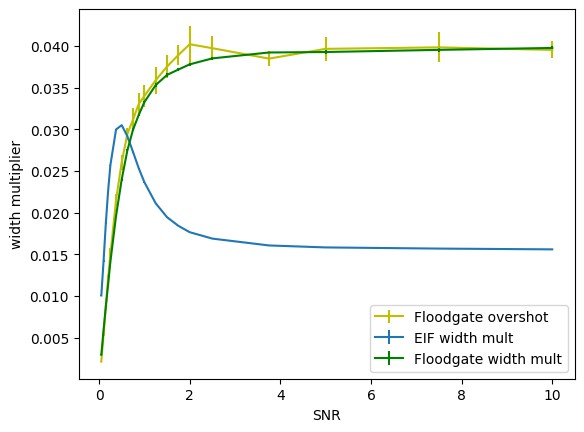

In [412]:
# display coverage/width multiplier results
display = 'width multiplier'
df = results_df_SNR_2
xlabel = 'SNR'

if display == 'coverage':
    label = 'coverage'
    plt.plot([-10,100],[0.8 for i in range(2)],label = 'nominal rate',color='r')
elif display == 'width multiplier':
    label = 'width mult'
    plt.errorbar(df.index,df['Floodgate overshot'], df['Floodgate overshot SE']*1.96,label = 'Floodgate overshot',color = 'y')
plt.errorbar(df.index,df['EIF '+display], df['EIF '+display + ' SE']*1.96,label = 'EIF '+ label)
plt.errorbar(df.index,df['Floodgate '+display],df['Floodgate ' +display + ' SE']*1.96,label = 'Floodgate ' + label,color='g')

plt.legend(loc = 'lower right')
plt.xlabel(xlabel)
plt.ylabel(display)

plt.xlim(1,10.1)
plt.ylim(0.725,0.925)
plt.xticks([1+i for i in range(10)])
plt.yticks([0.725+0.025*i for i in range(9)])
plt.show()

In [415]:
results_df_copy = results_df
results_df_null_copy = results_df_null
results_df_SNR_1_copy = results_df_SNR_1
results_df_SNR_2_copy = results_df_SNR_2